In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')
import os

from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from data.mouse import create_mice_dict
from plotting.main_plotting import plot_session_events_and_signal
from analysis.timepoint_analysis import sample_signals_and_metrics
from itertools import product

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import scipy.stats as stats
from tqdm.notebook import tqdm
from collections import defaultdict

import config

sessions = load_and_prepare_sessions("../../../trial_Gq-DREADD_CPT", load_from_pickle=True, remove_bad_signal_sessions=True)

from processing.plotting_setup import PlottingSetup
plotting_setup = PlottingSetup(**config.PLOTTING_CONFIG['cpt'])
plotting_setup.apply_plotting_setup_to_sessions(sessions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def update_genotypes(sessions, mice_gen_dict):
    """
    Updates the genotypes for a list of sessions based on the provided genotype mapping.
    Prints whether the genotypes are valid ('TH-Cre', 'Wildtype') 
    and the number of genotype changes made.

    Parameters:
    - sessions: A list of session objects to process.
    - mice_gen_dict: A dictionary mapping mouse IDs to new genotypes.
    """
    geno_mapping = {
        "Cre": "TH-Cre",
        "WT": "Wildtype"
    }
    # Map mice_gen_dict to use TH-Cre and Wildtype
    mapped_genotypes = {k: geno_mapping[v] for k, v in mice_gen_dict.items()}
    
    # Initialize counters and trackers
    valid_genotypes = {'TH-Cre', 'Wildtype'}
    all_genotypes = set()
    genotype_changes = 0

    for session in sessions:
        original_genotype = session.genotype
        int_id = int(session.mouse_id)
        
        if int_id in mapped_genotypes:
            session.genotype = mapped_genotypes[int_id]
            # Count changes if the genotype was updated
            if session.genotype != original_genotype:
                genotype_changes += 1
        
        all_genotypes.add(session.genotype)
    
    # Print results
    if all_genotypes.issubset(valid_genotypes):
        print(f"Valid genotypes found: {all_genotypes}")
    else:
        print(f"Invalid genotypes found: {all_genotypes}")
    
    print(f"Genotype changes made: {genotype_changes}")

In [4]:
mice_gen_dict = {
    69: "Cre",
    71: "WT",
    73: "Cre",
    75: "WT",
    77: "Cre",
    79: "WT",
    85: "WT",
    87: "WT",
    135: "WT",
    137: "WT",
    139: "Cre",
    133: "WT",
    127: "WT",
    125: "WT",
    129: "Cre",
    131: "WT",
    143: "Cre",
    145: "WT",
    147: "WT",
    157: "Cre",
    159: "Cre",
    161: "WT",
    171: "Cre",
    173: "Cre"
}

In [5]:
update_genotypes(sessions, mice_gen_dict)

Valid genotypes found: {'TH-Cre', 'Wildtype'}
Genotype changes made: 2


In [6]:
session_skips = ['T' + str(id) for id in list(range(1, 6)) + list(range(31, 35))]
sessions = [s for s in sessions if s.trial_id.split('_')[0] not in session_skips]

In [7]:
import matplotlib.pyplot as plt
import pickle

In [8]:
brain_reg_to_color = {'LH': 'orange',
                      'mPFC': 'cornflowerblue'}

In [9]:
all_signal_groups = defaultdict(list)

for session in sessions:
    genotype = session.genotype
    dose = session.drug_info['dose']
    for brain_reg in session.brain_regions:
        phot_df = session.dfs.data['phot_470']
        phot_times = phot_df['SecFromZero_FP3002'].values
        raw_df = session.dfs.data['raw']
    
        signal = phot_df[brain_reg + ('phot_zF',)]
        # signal = phot_df[f'{brain_reg}_phot_zF']
        blank_image_time = raw_df.iloc[session.cpt]['SecFromZero_FP3002']
        cpt_start_signal_idx = np.searchsorted(phot_times, blank_image_time, side='left')

        # Extract the desired slice and convert to a numpy array with shape (n, 1)
        signal_array = signal.iloc[cpt_start_signal_idx- 20*60*10:cpt_start_signal_idx+36000].to_numpy()
        curr_key = (genotype, dose, brain_reg)
        all_signal_groups[curr_key].append(signal_array)
        
# all_signal_groups = {k: np.stack(v) for k, v in all_signal_groups.items()}

all_signal_groups = {k: v for k, v in all_signal_groups.items()}
print(len(all_signal_groups[('TH-Cre', '2.0', ('mPFC', 'left', 'G'))]))
###

###

# with open('all_session_averages_1.pkl', 'wb') as file:
#     # Dump the dictionary into the file
#     pickle.dump(all_signal_groups, file)


12


In [10]:
{k: v for k, v in all_signal_groups.items() if k == ('TH-Cre', '2.0', ('mPFC', 'left', 'G'))}.keys()

dict_keys([('TH-Cre', '2.0', ('mPFC', 'left', 'G'))])

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_signal(signal, window_len=11):
    window = np.ones(window_len) / window_len
    return np.convolve(signal, window, mode='valid')

# Parameters
start_time = -10  # Start time in arbitrary units
end_time = 30  # End time in arbitrary units
smoothing_window = 101  # Smoothing window length
y_axis_normalization = 'genotype_brain_region'  # Options: 'individual', 'global', 'genotype', 'brain_region', 'genotype_brain_region'

mean_signals = {}  # key: curr_key, value: mean_signal
ci_95_signals = {}  # key: curr_key, value: ci_95

# Initialize y-limits
global_y_min, global_y_max = float('inf'), float('-inf')
genotype_to_y_limits = {}
brain_region_to_y_limits = {}
genotype_brain_region_to_y_limits = {}

# First pass: compute mean signals and y-limits
for curr_key, data in all_signal_groups.items():
    # Apply smoothing to the data
    smoothed_data = np.apply_along_axis(smooth_signal, 1, data, window_len=smoothing_window)
    
    # Calculate the mean and standard error of the mean (SEM) across the first dimension
    mean_signal = np.mean(smoothed_data, axis=0)
    sem_signal = np.std(smoothed_data, axis=0) / np.sqrt(smoothed_data.shape[0])
    
    # Calculate the 95% confidence interval
    ci_95 = 1.96 * sem_signal
    
    # Store the mean_signal and ci_95
    mean_signals[curr_key] = mean_signal
    ci_95_signals[curr_key] = ci_95
    
    # Update y-limits
    lower = mean_signal - ci_95
    upper = mean_signal + ci_95
    y_min = np.min(lower)
    y_max = np.max(upper)
    
    # Update global y-limits
    global_y_min = min(global_y_min, y_min)
    global_y_max = max(global_y_max, y_max)
    
    # Extract grouping keys
    genotype, dose, brain_reg = curr_key
    brain_reg = brain_reg[0]
    genotype_brain_reg = (genotype, brain_reg)
    
    # Update genotype y-limits
    if genotype not in genotype_to_y_limits:
        genotype_to_y_limits[genotype] = [float('inf'), float('-inf')]
    genotype_to_y_limits[genotype][0] = min(genotype_to_y_limits[genotype][0], y_min)
    genotype_to_y_limits[genotype][1] = max(genotype_to_y_limits[genotype][1], y_max)
    
    # Update brain_region y-limits
    if brain_reg not in brain_region_to_y_limits:
        brain_region_to_y_limits[brain_reg] = [float('inf'), float('-inf')]
    brain_region_to_y_limits[brain_reg][0] = min(brain_region_to_y_limits[brain_reg][0], y_min)
    brain_region_to_y_limits[brain_reg][1] = max(brain_region_to_y_limits[brain_reg][1], y_max)
    
    # Update genotype_brain_region y-limits
    if genotype_brain_reg not in genotype_brain_region_to_y_limits:
        genotype_brain_region_to_y_limits[genotype_brain_reg] = [float('inf'), float('-inf')]
    genotype_brain_region_to_y_limits[genotype_brain_reg][0] = min(genotype_brain_region_to_y_limits[genotype_brain_reg][0], y_min)
    genotype_brain_region_to_y_limits[genotype_brain_reg][1] = max(genotype_brain_region_to_y_limits[genotype_brain_reg][1], y_max)

# Plotting loop
for curr_key in all_signal_groups.keys():
    mean_signal = mean_signals[curr_key]
    ci_95 = ci_95_signals[curr_key]
    
    # Generate x-axis values
    x_values = np.linspace(start_time, end_time, mean_signal.shape[0])
    
    # Plot the data with fill between for 95% CI
    genotype, dose, brain_reg = curr_key
    brain_reg = brain_reg[0]
    color = brain_reg_to_color[brain_reg]
    
    plt.figure(dpi=300)
    # plt.plot(x_values, mean_signal, label='mean signal', color=color)
    # plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.5, label='95% CI', color=color)
    plt.plot(x_values, mean_signal, label='mean signal')
    plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.5, label='95% CI')
    plt.axvline(x=0, color='grey', linestyle='--')
    plt.title(f'Genotype: {genotype}, Dose: {dose}, Brain Region: {brain_reg}')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('zF - score') 
    plt.legend()
    plt.grid()
    
    # Set y-axis limits based on the y_axis_normalization flag
    if y_axis_normalization == 'global':
        plt.ylim(global_y_min, global_y_max)
    elif y_axis_normalization == 'genotype':
        y_min, y_max = genotype_to_y_limits[genotype]
        plt.ylim(y_min, y_max)
    elif y_axis_normalization == 'brain_region':
        y_min, y_max = brain_region_to_y_limits[brain_reg]
        plt.ylim(y_min, y_max)
    elif y_axis_normalization == 'genotype_brain_region':
        y_min, y_max = genotype_brain_region_to_y_limits[(genotype, brain_reg)]
        plt.ylim(y_min, y_max)
    elif y_axis_normalization == 'individual':
        pass  # Use default y-limits for individual plots
    else:
        pass  # Unknown option, do not set y-limits

    # plt.savefig(f'{genotype}_{dose}_{brain_reg}_session_mean_CPT_{y_axis_normalization}.png')
    plt.close('all')


In [12]:
def smooth_signal(signal, window_len=11):
    window = np.ones(window_len) / window_len
    return np.convolve(signal, window, mode='valid')


# Parameters
start_time = -10  # Start time in arbitrary units
end_time = 30  # End time in arbitrary units
smoothing_window = 101  # Smoothing window length

for curr_key, data in all_signal_groups.items():
    # Apply smoothing to the data
    smoothed_data = np.apply_along_axis(smooth_signal, 1, data, window_len=smoothing_window)
    
    # Calculate the mean and standard error of the mean (SEM) across the first dimension
    mean_signal = np.mean(smoothed_data, axis=0)
    sem_signal = np.std(smoothed_data, axis=0) / np.sqrt(smoothed_data.shape[0])
    
    # Calculate the 95% confidence interval
    ci_95 = 1.96 * sem_signal
    
    # Generate x-axis values
    x_values = np.linspace(start_time, end_time, mean_signal.shape[0])
    
    # Plot the data with fill between for 95% CI
    genotype, dose, brain_reg = curr_key
    brain_reg = brain_reg[0]
    color = brain_reg_to_color[brain_reg]

    plt.figure(dpi=300)
    # plt.plot(x_values, mean_signal, label='mean signal', color=color)
    # plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.5, label='ci 95%', color=color)
    plt.plot(x_values, mean_signal, label='mean signal')
    plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.5, label='ci 95%')
    plt.axvline(x=0, color='grey', linestyle='--')
    plt.title(f'genotype: {genotype}, dose: {dose}, brain region: {brain_reg}')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('zF - score') 
    plt.legend()
    plt.grid()
    if brain_reg == 'mPFC':
        plt.ylim(-2, 30)
    else:
        plt.ylim(-2, 15)

    # Define the folder path
    output_folder = "session_means"

    # Create the folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the files in the specified folder
    # plt.savefig(os.path.join(output_folder, f'{genotype}_{dose}_{brain_reg}_session_mean_CPT.png'))
    # plt.savefig(os.path.join(output_folder, f'{genotype}_{dose}_{brain_reg}_session_mean_CPT.pdf'))
    plt.close('all')

In [13]:
dose_to_color = {
    '0.1': 'C0',
    '0.5': 'C1',
    '2.0': 'C3',
}

C0 0.1
C1 0.5
C3 2.0
C2 None


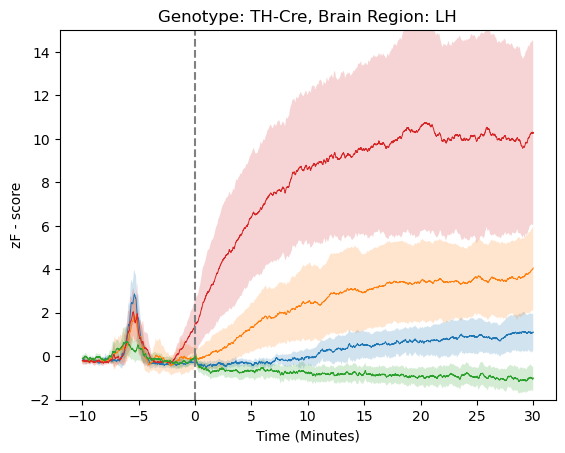

C0 0.1
C1 0.5
C3 2.0
C2 None


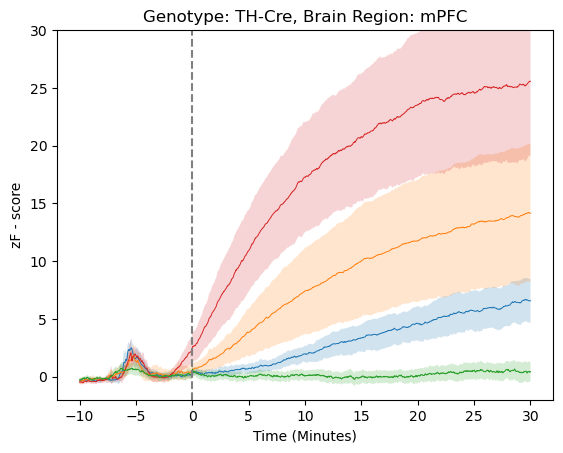

C3 2.0
C2 None
C1 0.5
C0 0.1


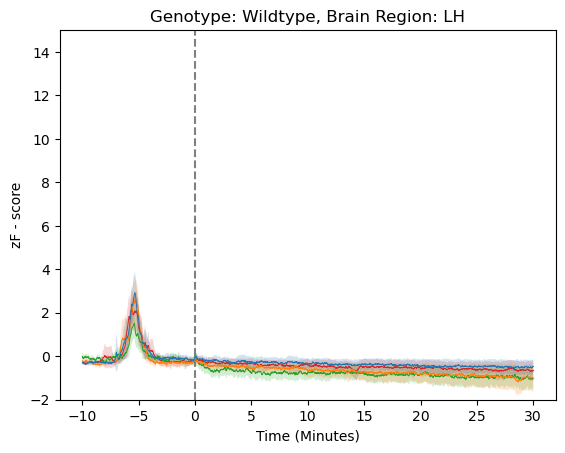

C3 2.0
C2 None
C1 0.5
C0 0.1


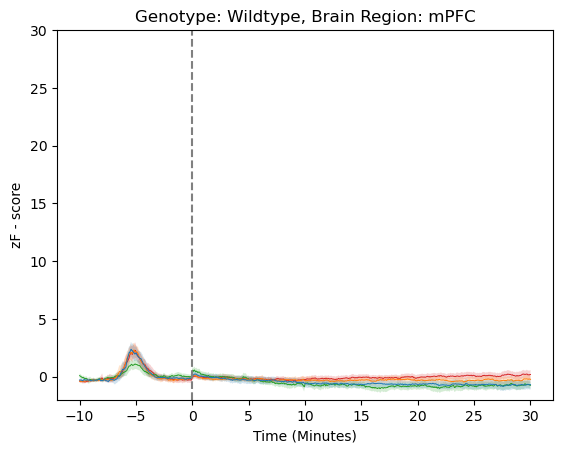

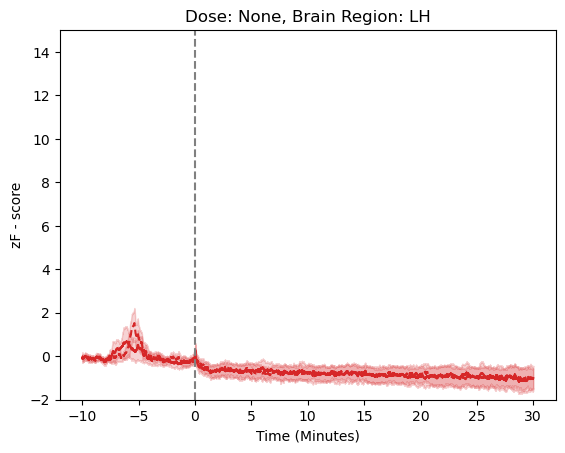

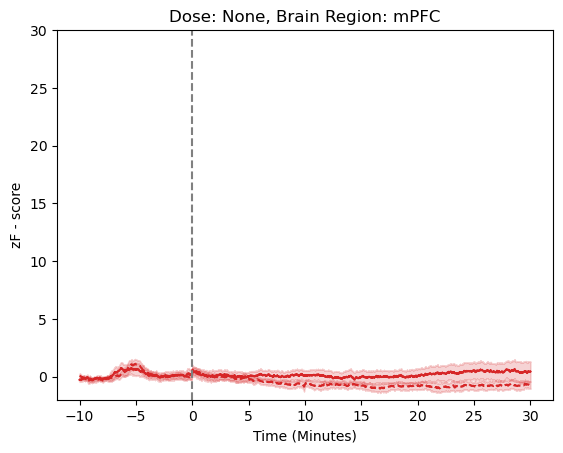

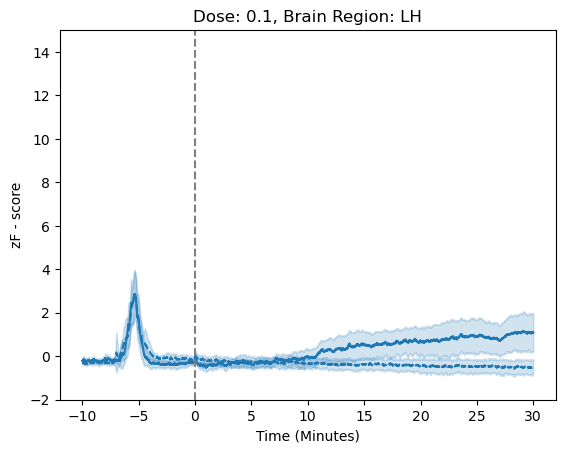

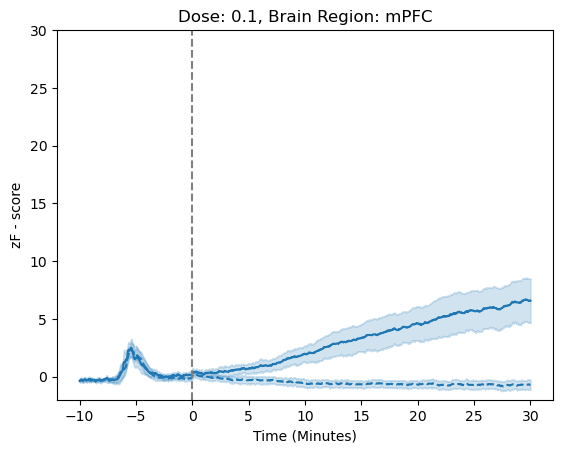

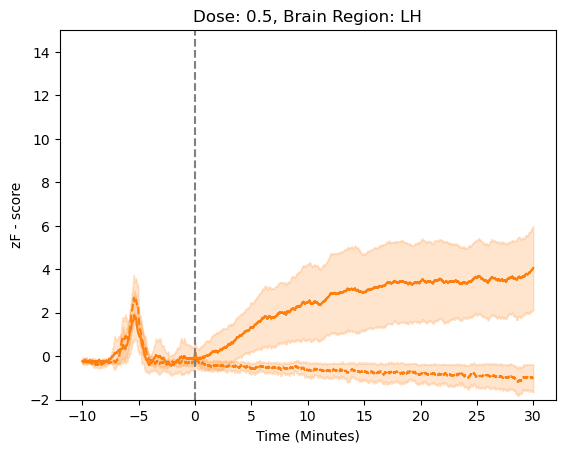

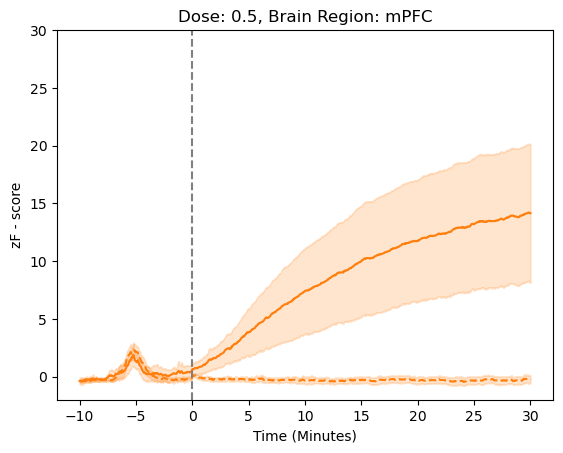

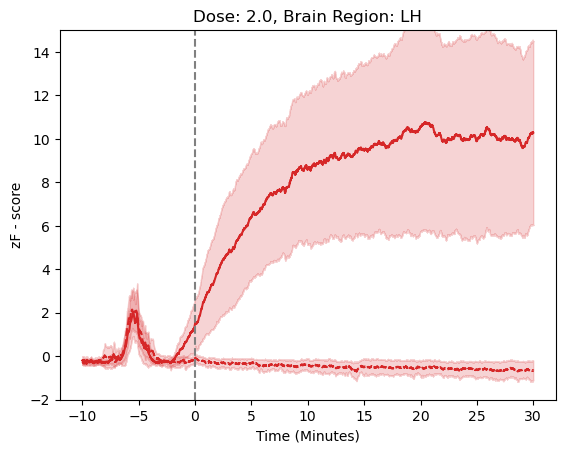

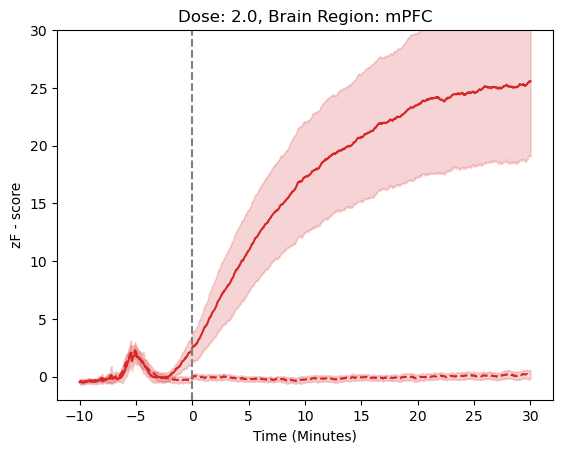

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from itertools import product
from matplotlib.colors import to_rgba

# Assuming brain_reg_to_color, all_signal_groups, smooth_signal are already defined

# --- Plot type 1: Genotype x Brain Region with Dose Overlay ---
unique_genotypes = sorted(list(set([k[0] for k in all_signal_groups.keys()])))
unique_brain_regions = sorted(list(set([k[2][0] for k in all_signal_groups.keys()])))
unique_doses = sorted(list(set([k[1] for k in all_signal_groups.keys()])), key=lambda x: (0 if x is None else 1, x))  # Sort with None first

saturation_levels = np.linspace(0.1, 1, len(unique_doses))

for genotype, brain_reg_base in product(unique_genotypes, unique_brain_regions):

    # Find relevant data for this genotype and brain region
    relevant_data = {k: v for k, v in all_signal_groups.items() if k[0] == genotype and k[2][0] == brain_reg_base}

    if not relevant_data:
        print('dose overlay not relevant!')
        continue

    # plt.figure(dpi=300)
    # ax = plt.gca()  # Get current axes for setting y-limits later
    plt.figure()

    # Determine y-limits for this plot
    local_y_min, local_y_max = float('inf'), float('-inf')
    for key, data in relevant_data.items():
        smoothed_data = np.apply_along_axis(smooth_signal, 1, data, window_len=smoothing_window)
        mean_signal = np.mean(smoothed_data, axis=0)
        sem_signal = np.std(smoothed_data, axis=0) / np.sqrt(smoothed_data.shape[0])
        ci_95 = 1.96 * sem_signal
        local_y_min = min(local_y_min, np.min(mean_signal - ci_95))
        local_y_max = max(local_y_max, np.max(mean_signal + ci_95))

    for key in relevant_data.keys():
        g, d, br_full = key
        mean_signal = mean_signals[key]
        ci_95 = ci_95_signals[key]
        x_values = np.linspace(start_time, end_time, mean_signal.shape[0])
        #color = brain_reg_to_color[brain_reg_base]
        color = dose_to_color.get(d, 'C2')
        print(color, d)

        # Get saturation level based on dose index
        try:
            dose_index = unique_doses.index(d)
            rgba_color = to_rgba(color)
            saturated_rgba = rgba_color[:3] + (saturation_levels[dose_index],)
        except ValueError:
            saturated_rgba = color  # Default if dose not found

        plt.plot(x_values, mean_signal, label=f'Dose: {d}', color=color, linewidth=0.7)
        plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.2, color=color, edgecolor='none')
        # plt.plot(x_values, mean_signal, label=f'Dose: {d}')
        # plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.5)

    plt.axvline(x=0, color='grey', linestyle='--')
    plt.title(f'Genotype: {genotype}, Brain Region: {brain_reg_base}')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('zF - score')
    # plt.legend()
    #plt.grid(True)

    # Set y-limits based on normalization choice
    if y_axis_normalization == 'global':
        plt.ylim(global_y_min, global_y_max)
    elif y_axis_normalization == 'genotype':
        plt.ylim(genotype_to_y_limits[genotype])
    elif y_axis_normalization == 'brain_region':
        plt.ylim(brain_region_to_y_limits[brain_reg_base])
    elif y_axis_normalization == 'genotype_brain_region':
        plt.ylim(genotype_brain_region_to_y_limits[(genotype, brain_reg_base)])
    elif y_axis_normalization == 'individual':
        plt.ylim(local_y_min, local_y_max) # Set local y-limits

    if brain_reg_base == 'mPFC':
        plt.ylim(-2, 30)
    else:
        plt.ylim(-2, 15)

    # Define the folder path
    output_folder = "cpt_dose_overlays_no_legend_grid_all_colors"

    # Create the folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the files in the specified folder
    # plt.savefig(os.path.join(output_folder, f'{genotype}_{brain_reg_base}_manual_ylim.png'))
    # plt.savefig(os.path.join(output_folder, f'{genotype}_{brain_reg_base}_manual_ylim.pdf'))
    # plt.savefig(os.path.join(output_folder, f'{genotype}_{brain_reg_base}_manual_ylim.svg'))
    plt.show()

# --- Plot type 2: Dose x Brain Region with Genotype Overlay ---
line_styles_geno = ['-', '--', ':', '-.', (0, (5, 10)), (0, (5, 5)), (0, (5, 1, 10, 1))] # More line styles

for dose, brain_reg_base in product(unique_doses, unique_brain_regions):

    # Find relevant data for this dose and brain region
    # relevant_data = {k: v for k, v in all_signal_groups.items() if k[1] == dose and k[2].startswith(brain_reg_base)}
    relevant_data = {k: v for k, v in all_signal_groups.items() if k[1] == dose and k[2][0] == brain_reg_base}

    if not relevant_data:
        continue

    # plt.figure(dpi=300)
    # ax = plt.gca() # Get current axes for setting y-limits later
    plt.figure()

    # Determine y-limits for this plot
    local_y_min, local_y_max = float('inf'), float('-inf')
    for key, data in relevant_data.items():
        smoothed_data = np.apply_along_axis(smooth_signal, 1, data, window_len=smoothing_window)
        mean_signal = np.mean(smoothed_data, axis=0)
        sem_signal = np.std(smoothed_data, axis=0) / np.sqrt(smoothed_data.shape[0])
        ci_95 = 1.96 * sem_signal
        local_y_min = min(local_y_min, np.min(mean_signal - ci_95))
        local_y_max = max(local_y_max, np.max(mean_signal + ci_95))

    for key in relevant_data.keys():
        g, d, br_full = key
        mean_signal = mean_signals[key]
        ci_95 = ci_95_signals[key]
        x_values = np.linspace(start_time, end_time, mean_signal.shape[0])
        # color = brain_reg_to_color[brain_reg_base]
        color = dose_to_color.get(dose, 'C3')

        # Get line style based on genotype index
        try:
            geno_index = unique_genotypes.index(g)
            line_style = line_styles_geno[geno_index % len(line_styles_geno)]
        except ValueError:
            line_style = '-'

        # plt.plot(x_values, mean_signal, label=f'Genotype: {g}', color=color, linestyle=line_style)
        # plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.2, color=color)
        plt.plot(x_values, mean_signal, label=f'Genotype: {g}', linestyle=line_style, color=color)
        plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.2, color=color)

    plt.axvline(x=0, color='grey', linestyle='--')
    plt.title(f'Dose: {dose}, Brain Region: {brain_reg_base}')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('zF - score')
    # plt.legend()
    #plt.grid(True)

    # Set y-limits based on normalization choice
    if y_axis_normalization == 'global':
        plt.ylim(global_y_min, global_y_max)
    elif y_axis_normalization == 'genotype':
        present_genotypes = [k[0] for k in relevant_data.keys()]
        combined_y_min = min([genotype_to_y_limits[g][0] for g in present_genotypes]) if present_genotypes else local_y_min
        combined_y_max = max([genotype_to_y_limits[g][1] for g in present_genotypes]) if present_genotypes else local_y_max
        plt.ylim(combined_y_min, combined_y_max)
    elif y_axis_normalization == 'brain_region':
        plt.ylim(brain_region_to_y_limits[brain_reg_base])
    elif y_axis_normalization == 'genotype_brain_region':
        present_genotype_brain_regions = [(k[0], k[2][0]) for k in relevant_data.keys()]
        combined_y_min = min([genotype_brain_region_to_y_limits[gbr][0] for gbr in present_genotype_brain_regions]) if present_genotype_brain_regions else local_y_min
        combined_y_max = max([genotype_brain_region_to_y_limits[gbr][1] for gbr in present_genotype_brain_regions]) if present_genotype_brain_regions else local_y_max
        plt.ylim(combined_y_min, combined_y_max)
    elif y_axis_normalization == 'individual':
        plt.ylim(local_y_min, local_y_max) # Set local y-limits

    # Define the folder path
    output_folder = "cpt_genotype_overlays_no_legend_grid_all_colors"

    if brain_reg_base == 'mPFC':
        plt.ylim(-2, 30)
    else:
        plt.ylim(-2, 15)

    # Create the folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the files in the specified folder
    plt.savefig(os.path.join(output_folder, f'{genotype}_{dose}_manual_ylim.png'))
    plt.savefig(os.path.join(output_folder, f'{genotype}_{dose}_manual_ylim.pdf'))
    plt.savefig(os.path.join(output_folder, f'{genotype}_{dose}_manual_ylim.svg'))
    plt.show()

# ITSHERE

In [2]:
import matplotlib.pyplot as plt

In [3]:
# brain_reg_to_color = {'VS': 'purple',
#                       'DMS': 'forestgreen',
#                       'DLS': 'C0'}

brain_reg_to_color = {'LH': 'orange',
                      'mPFC': 'cornflowerblue'}

In [4]:
import pickle

with open('all_signals_1.pickle', 'rb') as file:
    # Load the data back into a Python object
    all_signals_1 = pickle.load(file)

with open('all_signals_2.pickle', 'rb') as file:
    # Load the data back into a Python object
    all_signals_2 = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'all_signals_1.pickle'

In [ ]:
all_signals_1[('hit', 'LH')].shape

In [5]:
all_signals = {}

for k in all_signals_1.keys():
    all_signals[k] = np.vstack([all_signals_1[k], all_signals_2[k]])

NameError: name 'all_signals_1' is not defined

In [6]:
def preprocess_and_plot_signals(sessions, event_type, brain_region, smoothing_len=10):
    # Assuming all_signals is predefined
    signals = all_signals[(event_type, brain_region)]

    interval_start = config.peak_interval_config["interval_start"]
    interval_end = config.peak_interval_config["interval_end"]
    fps = config.PLOTTING_CONFIG['fps']
    
    xs = np.arange(-interval_start, interval_end) / fps
    
    # Smooth the mean signal
    ys = np.mean(signals, axis=0)
    window = np.ones(smoothing_len) / smoothing_len
    ys = np.convolve(ys, window, 'same')

    # Calculate the standard deviation of the mean
    std_signal = np.std(signals, axis=0) / np.sqrt(len(signals))

    # Use scipy.stats.norm.interval to get the 95% confidence interval
    alpha = 0.95
    ci_lower, ci_upper = stats.norm.interval(alpha, loc=ys, scale=std_signal)

    # The lower and upper bounds
    lb = ci_lower.min()
    ub = ci_upper.max()

    ylim = (lb, ub)
    
    # Assuming brain_reg_to_color is predefined
    color = brain_reg_to_color[brain_region]

    plt.figure(dpi=300)
    # plt.plot(xs, ys, color=color, label='Mean Signal')
    # plt.fill_between(xs, ci_lower, ci_upper, color=color, alpha=0.2, label='95% CI')
    plt.plot(xs, ys, label='Mean Signal')
    plt.fill_between(xs, ci_lower, ci_upper, alpha=0.2, color=color, label='95% CI')
    plt.ylim(ylim)
    plt.title(f'{event_type}, {brain_region}, (n = {len(signals)})')
    plt.xlabel('Time (s)')
    plt.ylabel('z-score')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the figure locally
    # filename = f'leonie_fig_{event_type}_{brain_region}.png'
    # plt.savefig(filename)
    # plt.show()

# Example usage
# Assuming sessions, config, all_signals, brain_reg_to_color are defined
for event_type, brain_reg in product(config.all_event_types, config.all_brain_regions):
    preprocess_and_plot_signals(sessions, event_type, brain_reg)

NameError: name 'product' is not defined

In [ ]:
import pickle

with open('all_signals_2.pickle', 'wb') as file:
    # Pickle the dictionary and write it to the file
    pickle.dump(all_signals, file)